In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
from time import time
from statistics import mean
import tempfile
from scipy.interpolate import griddata

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Plotting functions

def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'fp', 'fn']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No fire (True Negatives): ', cm[0][0])
    print('False alarms (False Positives): ', cm[0][1])
    print('Fires missed (False Negatives): ', cm[1][0])
    print('Fires detected (True Positives): ', cm[1][1])
    print('Total fires: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def regularize_grid(x, y, z, resolution):
    # Takes three coordinate grids and a resolution
    # interpolates and resamples so frequencys match
    # returns regularized data. For use in
    # constructing heatmaps

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

In [5]:
# Data variables
raw_train_data_file = '../data/stratified_training_data/1992-2015_training_data_raw_n100000_ks_pval0.3.1.csv'
raw_test_data_files = [
    '../data/stratified_training_data/1992-2015_training_data_raw_n100000_ks_pval0.3.2.csv',
    '../data/stratified_training_data/1992-2015_training_data_raw_n100000_ks_pval0.3.3.csv',
    '../data/stratified_training_data/1992-2015_training_data_raw_n100000_ks_pval0.3.4.csv',
    '../data/stratified_training_data/1992-2015_training_data_raw_n100000_ks_pval0.3.5.csv',
    '../data/stratified_training_data/1992-2015_training_data_raw_n100000_ks_pval0.3.6.csv'
]

# Datatypes for dataframe loading
dtypes = {
    'weather_bin_time': object,
    'lat': float,
    'lon': float,
    'air.sfc': float,
    'rhum.2m': float,
    'dpt.2m': float,
    'pres.sfc': float,
    'uwnd.10m': float,
    'vwnd.10m': float,
    'veg': float,
    'dlwrf': float,
    'dswrf': float,
    'lcdc': float,
    'hcdc': float,
    'mcdc': float,
    'hpbl': float,
    'ulwrf.sfc': float,
    'ignition': float,
    'weather_bin_day': int,
    'weather_bin_month': int,
    'weather_bin_year': int
}

# Features to use during training 
features = [
    'weather_bin_month',
    'weather_bin_year',
    'air.sfc',
    'rhum.2m',
    'dpt.2m',
    'pres.sfc',
    'uwnd.10m', 
    'vwnd.10m',
    'veg',
    'lat',
    'lon',
    'ignition'
]

In [6]:
# Load data
raw_train_data = pd.read_csv(raw_train_data_file, dtype=dtypes)

raw_test_data_sets = []

for raw_test_data_file in raw_test_data_files:
    raw_test_data = pd.read_csv(raw_test_data_file, dtype=dtypes)
    raw_test_data_sets.append(raw_test_data)

In [7]:
# Count number of observations in each training class
train_total = len(raw_train_data)
train_no_ignition_count = len(raw_train_data[raw_train_data["ignition"] == 0])
train_ignition_count = train_total - train_no_ignition_count
train_ignition_percent = np.round(((train_ignition_count / train_total)*100),1)
print("Train set: {} total, {}% ignition.".format(train_total, train_ignition_percent))

# Count number of observations in each testing class
i = 1

for raw_test_data in raw_test_data_sets:
    test_total = len(raw_test_data)
    test_no_ignition_count = len(raw_test_data[raw_test_data["ignition"] == 0])
    test_ignition_count = test_total - test_no_ignition_count
    test_ignition_percent = np.round(((test_ignition_count / test_total)*100),1)

    print("Test set {}: {} total, {}% ignition.".format(i, test_total, test_ignition_percent))
    
    i +=1

Train set: 56718 total, 4.6% ignition.
Test set 1: 56717 total, 4.7% ignition.
Test set 2: 56718 total, 4.5% ignition.
Test set 3: 56717 total, 4.7% ignition.
Test set 4: 56718 total, 4.5% ignition.
Test set 5: 56717 total, 4.6% ignition.


In [8]:
# Prep test data
test_data_sets = []
test_label_sets = []
test_feature_sets = []

for raw_test_data in raw_test_data_sets:
    test_data = raw_test_data[features]
    test_data_sets.append(test_data)
    
    test_labels = np.array(test_data.pop('ignition'))
    test_label_sets.append(test_labels)
    
    test_features = np.array(test_data)
    test_feature_sets.append(test_features)

In [9]:
# Prep train data
# Get only desired features from raw data
train_data = raw_train_data[features]

# Split training data into train and validation sets
train_data, validation_data = train_test_split(train_data, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_data.pop('ignition'))
bool_train_labels = train_labels != 0
validation_labels = np.array(validation_data.pop('ignition'))

train_features = np.array(train_data)
validation_features = np.array(validation_data)

In [10]:
# convert data to z-score
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)
test_features = scaler.transform(test_features)

# clip at 5 standard deviations
train_features = np.clip(train_features, -5, 5)
validation_features = np.clip(validation_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [11]:
# Model setup

# Evaluation metrics
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Class weights
weight_for_0 = (1 / train_no_ignition_count)*(train_total)/2.0 
weight_for_1 = (1 / train_ignition_count)*(train_total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# Inital output bias
initial_bias = np.log([train_ignition_count/train_no_ignition_count])
output_bias = tf.keras.initializers.Constant(initial_bias)

# Training hyperparameters
EPOCHS = 50
BATCH_SIZE = int(2048 * 4)

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

result_data_columns=[
    'Hidden layers',
    'Neurons per layer',
    'False positives',
    'False negatives',
    'True positives',
    'True negatives',
    'Precision',
    'Accuracy',
    'Recall',
    'AUC',
    'Mean true positive',
    'Mean false positive',
    'Mean true negative',
    'Mean false negative',
    'Mean accuracie',
    'Mean precision',
    'Mean recall',
    'Mean auc',
    'Run time'
]
# Start empty dataframe to hold results
result_data = pd.DataFrame(columns=result_data_columns)

In [12]:
rounds = 20
hidden_layers = 1

for i in range(rounds):
    neurons_per_layer = len(features)
    
    for j in range(rounds):
        # Define the keras model
        model = keras.Sequential()
        model.add(keras.layers.Dense(neurons_per_layer, activation='relu', input_dim=(train_features.shape[-1])))

        for n in range(hidden_layers):
            model.add(keras.layers.Dense(neurons_per_layer, activation='relu'))
            n += 1
            
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

        model.compile(
            optimizer=keras.optimizers.Adam(lr=1e-3),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics,
        )

        start = time()
        
        print("Training with {} layers and {} neurons per layer".format(hidden_layers, neurons_per_layer))
        
        train_history = model.fit(
            train_features,
            train_labels,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks = [early_stopping],
            validation_data=(validation_features, validation_labels),
            class_weight=class_weight,
            verbose=0
        )
        
        dT = (time() - start)/60
        
        true_positives = []
        false_positives = []
        true_negatives = []
        false_negatives = []
        accuracies = []
        precisions = []
        recalls = []
        aucs = []
        
        for test_labels, test_features in zip(test_label_sets, test_feature_sets):
            test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)
            results = model.evaluate(
                test_features,
                test_labels,
                batch_size=BATCH_SIZE, 
                verbose=0
            )
            
            true_positives.append(results[0])
            false_positives.append(results[1])
            true_negatives.append(results[2])
            false_negatives.append(results[3])
            accuracies.append(results[4])
            precisions.append(results[5])
            recalls.append(results[6])
            aucs.append(results[7])
            
        mean_true_positives = mean(true_positives)
        mean_false_positives = mean(false_positives)
        mean_true_negatives = mean(true_negatives)
        mean_false_negatives = mean(false_negatives)
        mean_accuracies = mean(accuracies)
        mean_precisions = mean(precisions)
        mean_recalls = mean(recalls)
        mean_aucs = mean(aucs)
            
        result_data = result_data.append(pd.Series([
            hidden_layers,
            neurons_per_layer,
            true_positives,
            false_positives,
            true_negatives,
            false_negatives,
            accuracies,
            precisions,
            recalls,
            aucs,
            mean_true_positives,
            mean_false_positives,
            mean_true_negatives,
            mean_false_negatives,
            mean_accuracies,
            mean_precisions,
            mean_recalls,
            mean_aucs,
            dT
        ], index=result_data.columns), ignore_index=True)
        
            
        neurons_per_layer += 2
        j += 1
        
    hidden_layers += 2
    i += 1

Training with 1 layers and 12 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 14 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Training with 1 layers and 16 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 18 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 20 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 22 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 24 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 26 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 28 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 1 layers and 30 neur

  ...
    to  
  ['...']
Training with 3 layers and 48 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 3 layers and 50 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 12 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 14 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 16 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 18 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 20 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 22 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 24 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 5 layers and 26 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['.

  ...
    to  
  ['...']
Training with 7 layers and 44 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 7 layers and 46 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Training with 7 layers and 48 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Training with 7 layers and 50 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Training with 9 layers and 12 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 9 layers and 14 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 9 layers and 16 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 9 layers and 18 neurons

Training with 11 layers and 36 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 11 layers and 38 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Training with 11 layers and 40 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 11 layers and 42 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Training with 11 layers and 44 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Training with 11 layers and 46 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Training with 11 layers and 48 neurons per layer
  ...
    to  
  ['..

  ...
    to  
  ['...']
Training with 15 layers and 26 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 15 layers and 28 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 15 layers and 30 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 15 layers and 32 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Training with 15 layers and 34 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 15 layers and 36 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 15 layers and 38 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 15 layers and 40 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Training with 1

  ...
    to  
  ['...']
Training with 19 layers and 14 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 16 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 18 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 20 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 22 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Training with 19 layers and 24 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 26 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 28 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 19 layers and 30 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']


Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Training with 21 layers and 40 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Training with 21 layers and 42 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 21 layers and 44 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 21 layers and 46 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Training with 21 layers and 48 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Training with 21 layers and 50 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00040: e

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Training with 25 layers and 28 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 25 layers and 30 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Training with 25 layers and 32 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 25 layers and 34 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 25 layers and 36 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 25 layers and 38 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 25 layers and 40 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 25 layers and 42 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of 

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Training with 29 layers and 14 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 29 layers and 16 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Training with 29 layers and 18 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 29 layers and 20 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 29 layers and 22 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 29 layers and 24 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 29 layers and 26 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Training with 29 layers and 28 neurons per layer
  ...


  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Training with 31 layers and 42 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Training with 31 layers and 44 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Training with 31 layers and 46 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Training with 31 layers and 48 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Training with 31 layers and 50 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoc

Training with 35 layers and 26 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Training with 35 layers and 28 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 35 layers and 30 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 35 layers and 32 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 35 layers and 34 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Training with 35 layers and 36 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Training with 35 layers and 38 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Training with 37 layers and 50 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Training with 39 layers and 12 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 39 layers and 14 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Training with 39 layers and 16 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Training with 39 layers and 18 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Training with 39 layers and 20 neurons per layer
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Restoring model weights from the end of the best epoch.
Epoch 00011: e

In [13]:
result_data.head(10)

,Hidden layers,Neurons per layer,False positives,False negatives,True positives,True negatives,Precision,Accuracy,Recall,AUC,Mean true positive,Mean false positive,Mean true negative,Mean false negative,Mean accuracie,Mean precision,Mean recall,Mean auc,Run time
0,1,12,"[48830.020184575944, 48877.527805464095, 48803...","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",48855.716038,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.106304
1,1,14,"[2976.562843997356, 2979.4239273773455, 2974.8...","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",2978.112986,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.057117
2,1,16,"[58016.91563079908, 58073.1749390901, 57984.83...","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",58047.341939,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.109226
3,1,18,"[57577.98193008985, 57633.551124780715, 57545....","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",57608.045702,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.113770
4,1,20,"[70338.07421317132, 70406.50443890167, 70299.3...","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",70375.053519,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.108903
5,1,22,"[60281.97979235172, 60340.42466980279, 60248.6...","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",60313.594423,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.118420
6,1,24,"[62548.19721014808, 62608.728437593665, 62513....","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",62580.949121,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.112659
7,1,26,"[35290.08224296452, 35324.608218924106, 35270....","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",35308.743666,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.115570
8,1,28,"[54402.72721465511, 54455.73659940958, 54372.8...","[2641.0, 2569.0, 2660.0, 2550.0, 2599.0]","[54076.0, 54149.0, 54057.0, 54168.0, 54118.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[0.046564523, 0.045294262, 0.04689952, 0.04495...","[1.0, 1.0, 1.0, 1.0, 1.0]",54431.390398,2603.800049,54113.601562,0.0,0.0,0.045908,0.045908,1.0,0.119558
9,1

In [14]:
X = np.array(result_data['Hidden layers'])

In [15]:
Y = np.array(result_data['Run time'])

In [16]:
Z = np.array(result_data['Neurons per layer'])

In [17]:
ax = sns.lineplot(x=X, y=Y, hue=Z)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Run time vs. network depth')
plt.show()

AttributeError: 'int' object has no attribute 'view'

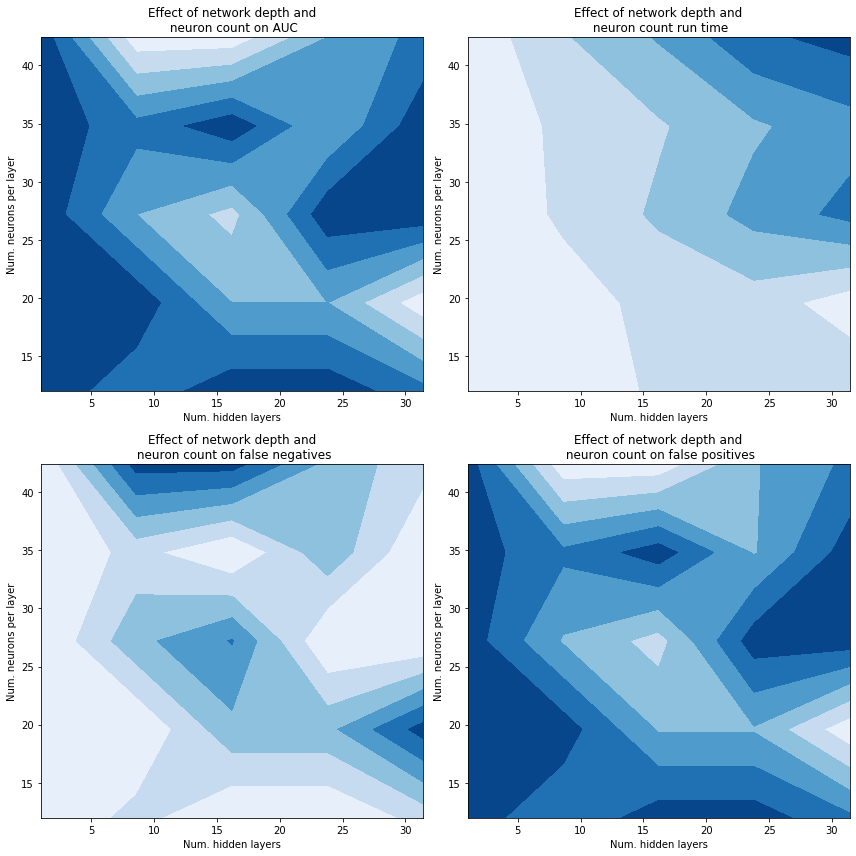

In [18]:
plot_grid_resolution = 5
contourf_levels = 5

plt.subplots(2,2,figsize=(12,12))

x = result_data['Hidden layers']
y = result_data['Neurons per layer']
z = result_data['Mean auc']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

plt.subplot(2, 2, 1)
plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Num. hidden layers")
plt.ylabel("Num. neurons per layer")
plt.title("Effect of network depth and\n neuron count on AUC")


x = result_data['Hidden layers']
y = result_data['Neurons per layer']
z = result_data['Run time']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

plt.subplot(2, 2, 2)
plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Num. hidden layers")
plt.ylabel("Num. neurons per layer")
plt.title("Effect of network depth and\n neuron count run time")


x = result_data['Hidden layers']
y = result_data['Neurons per layer']
z = result_data['Mean false negative']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

plt.subplot(2, 2, 3)

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Num. hidden layers")
plt.ylabel("Num. neurons per layer")
plt.title("Effect of network depth and\n neuron count on false negatives")


x = result_data['Hidden layers']
y = result_data['Neurons per layer']
z = result_data['Mean false positive']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

plt.subplot(2, 2, 4)

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("Num. hidden layers")
plt.ylabel("Num. neurons per layer")
plt.title("Effect of network depth and\n neuron count on false positives")

plt.tight_layout()
plt.show()

In [ ]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall', 'fp', 'fn']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
    if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
        
    elif metric == 'auc':
        plt.ylim([0.8,1])
        
    else:
        #plt.ylim([0,1])
        plt.legend()
        
plot_metrics(train_history)

In [ ]:
train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
results

In [ ]:
score = map(model.metrics_names, results)

In [ ]:
score

In [ ]:
results = model.evaluate(
    test_features,
    test_labels,
    batch_size=BATCH_SIZE, 
    verbose=0
)

for name, value in zip(model.metrics_names, results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions)

In [ ]:
plot_roc("Train", train_labels, train_predictions, color=colors[1])
plot_roc("Test", test_labels, test_predictions, color=colors[1], linestyle='--')
plt.legend(loc='lower right')
plt.show()